In [119]:
import matplotlib.pyplot as plt
from scipy.stats import entropy
import seaborn as sns
import pandas as pd
import glob
import numpy as np
from scipy.special import softmax
import re

def process_logits(logit_str, top_p=None):
    logit_lines = logit_str.split('\n')
    instruction, prompt, _ = logit_lines[:3]
    sequence_logits = []
    for idx, line in enumerate(logit_lines[3:]):
        if line == '':
            continue
        logit_type, logits = line.split()[0].replace(':', ''), line.split()[1:]
        logits = list(map(lambda x: round(float(x), 4), logits))

        l_entropy = entropy(softmax(logits), base=2)
        # if `top_p` is specified, we just get the top p tokens, otherwise we get logits for all tokens.
        if top_p is not None:
            logits = get_top_p_tokens(logits, p=top_p)

        sequence_logits.append({
            'entropy': l_entropy,
            'logit_type': logit_type,
            'logits': logits,
            'idx': int(idx / 2)
        })

    return {
        'instruction': instruction,
        'prompt': prompt,
        'all_logits': sequence_logits,
    }

def process_logits_group_prompted_and_unprompted(logit_str, top_p=None):
    logit_lines = logit_str.split('\n')
    instruction, prompt, _ = logit_lines[:3]
    sequence_logits = []
    prompted_logits = None
    for idx, line in enumerate(logit_lines[3:]):
        if line == '':
            continue

        logit_type, logits = line.split()[0].replace(':', ''), line.split()[1:]
        logits = np.array(list(map(lambda x: float(x), logits)))
        if logit_type == 'prompted_logits':
            prompted_logits = logits
        else:
            unprompted_logits = logits

            cfg = 1.5
            cfg_logits = cfg * prompted_logits + (1 - cfg) * unprompted_logits
            top_p_prompted_tokens = get_top_p_tokens(prompted_logits, p=top_p)
            top_p_prompted_logits = softmax(prompted_logits)[top_p_prompted_tokens]
            top_p_cfg_tokens = get_top_p_tokens(cfg_logits, p=top_p)
            top_p_cfg_logits = softmax(cfg_logits)[top_p_cfg_tokens]
            prompted_unprompted_l2_distance = np.linalg.norm(softmax(prompted_logits) - softmax(unprompted_logits))
            cfg_prompted_l2_distance = np.linalg.norm(softmax(cfg_logits) - softmax(prompted_logits))

            sequence_logits.append({
                'prompted_top_k': top_p_prompted_tokens,
                'cfg_prompted_top_k': top_p_cfg_tokens,
                'prompted_logits': top_p_prompted_logits,
                'cfg_logits': top_p_cfg_logits,
                'idx': int(idx / 2),
                'prompted_unprompted_l2_distance': prompted_unprompted_l2_distance,
                'cfg_prompted_l2_distance': cfg_prompted_l2_distance
            })

    return {
        'instruction': instruction,
        'prompt': prompt,
        'all_logits': sequence_logits,
    }


def get_top_p_tokens(logits, p=.9):
    ps = softmax(logits)
    arg_sorted_desc = ps.argsort()[::-1]
    cumprobs = np.cumsum(ps[arg_sorted_desc])
    top_p = cumprobs[cumprobs < p].shape[0]
    top_p = max(top_p, 1)
    top_p_tokens = arg_sorted_desc[:top_p]
    return top_p_tokens

# Read in Files

In [69]:
all_logit_files = glob.glob('../sample-trial-logit-outputs/logit-files__*')
models = list(map(lambda x: re.search('logit-files__(.*)__(\d+).txt', x).groups(), all_logit_files))

In [70]:
from tqdm.auto import tqdm

In [120]:
all_logits = []
for m, f in tqdm(zip(models, all_logit_files), total=len(models)):
    all_logits.append({
        'model': m[0],
        'prompt_num': int(m[1]),
        # 'logits_parsed': process_logits(open(f).read()),
        'top_p_tokens': process_logits(open(f).read(), top_p=.9),
        'top_p_prompted_change': process_logits_group_prompted_and_unprompted(open(f).read(), top_p=.9)
    })

  0%|          | 0/15 [00:00<?, ?it/s]

In [121]:
all_logits_df = pd.DataFrame(all_logits)

# Edit Distance

Text(0, 0.5, 'L2')

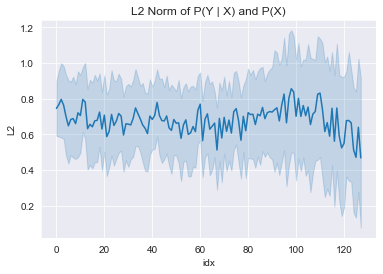

In [126]:
(all_logits_df
 ['top_p_prompted_change']
 .pipe(lambda df: pd.concat(list(map(lambda x: pd.DataFrame(x['all_logits']), df))))
 .reset_index(drop=True)
 .pipe(lambda df: sns.lineplot(data=df, x='idx', y='prompted_unprompted_l2_distance'))
 )
plt.title('L2 Norm of P(Y | X) and P(X)')
plt.ylabel('L2')

Text(0, 0.5, 'L2')

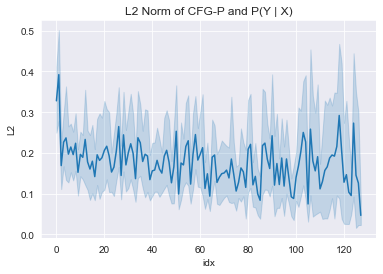

In [125]:
(all_logits_df
 ['top_p_prompted_change']
 .pipe(lambda df: pd.concat(list(map(lambda x: pd.DataFrame(x['all_logits']), df))))
 .reset_index(drop=True)
 .pipe(lambda df: sns.lineplot(data=df, x='idx', y='cfg_prompted_l2_distance'))
 )
plt.title('L2 Norm of CFG-P and P(Y | X)')
plt.ylabel('L2')

Text(0, 0.5, 'Number of Tokens')

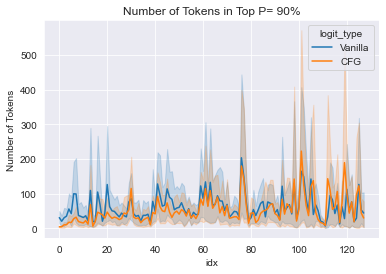

In [90]:
(all_logits_df
 ['top_p_prompted_change']
 .pipe(lambda df: pd.concat(list(map(lambda x: pd.DataFrame(x['all_logits']), df))))
 .assign(num_cfg_prompted_top_k=lambda df: df['cfg_prompted_top_k'].str.len())
 .assign(num_prompted_top_k=lambda df: df['prompted_top_k'].str.len())
 .set_index('idx')[['num_prompted_top_k', 'num_cfg_prompted_top_k']]
 .unstack()
 .reset_index().rename(columns={'level_0': 'logit_type', 0: 'num_tokens'})
.assign(logit_type=lambda df: df['logit_type'].map({'num_prompted_top_k': 'Vanilla', 'num_cfg_prompted_top_k': 'CFG'}))
.pipe(lambda df: sns.lineplot(data=df, x='idx', y='num_tokens', hue='logit_type'))
)
plt.title('Number of Tokens in Top P= 90%')
plt.ylabel('Number of Tokens')

In [94]:
from polyleven import levenshtein
import textdistance

ModuleNotFoundError: No module named 'textdistance.levenshtein'

In [108]:
t_df = (all_logits_df
 ['top_p_prompted_change']
 .pipe(lambda df: pd.concat(list(map(lambda x: pd.DataFrame(x['all_logits']), df))))
 .assign(leven_distance=lambda df:
         df.apply(lambda x: textdistance.levenshtein.distance(
             x['prompted_top_k'].tolist(),
             x['cfg_prompted_top_k'].tolist()
            ), axis=1)
         )
 )

<AxesSubplot:xlabel='idx', ylabel='leven_distance'>

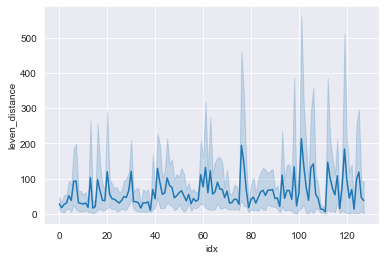

In [111]:
sns.lineplot(data=t_df.reset_index(drop=True), x='idx', y='leven_distance')

# Entropy

In [74]:
import seaborn as sns

<AxesSubplot:xlabel='idx', ylabel='entropy'>

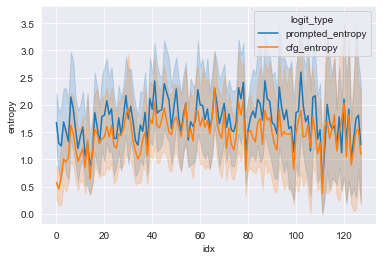

In [82]:
(all_logits_df
['top_p_prompted_change']
 .pipe(lambda df: pd.concat(list(map(lambda x: pd.DataFrame(x['all_logits']), df))))
 .assign(prompted_entropy=lambda df: df['prompted_logits'].apply(entropy))
 .assign(cfg_entropy=lambda df: df['cfg_logits'].apply(entropy))
 .set_index('idx')[['prompted_entropy', 'cfg_entropy']]
 .unstack()
 .reset_index().rename(columns={'level_0': 'logit_type', 0: 'entropy'})
.pipe(lambda df: sns.lineplot(data=df, x='idx', y='entropy', hue='logit_type'))
 )

<AxesSubplot:xlabel='idx', ylabel='entropy'>

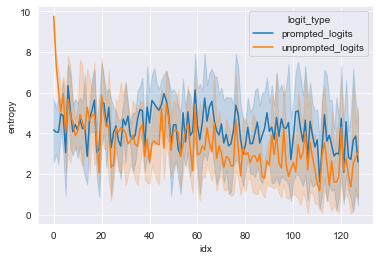

In [36]:
(all_logits_df['top_p_tokens']
 .pipe(lambda s: pd.DataFrame(s.tolist()))
 .head()['all_logits']
 .pipe(lambda s: pd.concat(list(map(lambda x: pd.DataFrame(x), s))))
 # .loc[lambda df: df['logit_type'] == 'prompted_logits']
 .pipe(lambda df: sns.lineplot(data=df.reset_index(drop=True), x='idx', y='entropy', hue='logit_type'))
)

In [40]:
def get_logit_statistics(one_doc):
    one_prompt_logits = pd.DataFrame(one_doc['top_p_tokens']['all_logits']).rename(columns={'logits': 'top_p_tokens'})
    one_prompt_logits = (one_prompt_logits
        .groupby('idx')
        .apply(lambda df:
            pd.Series({
                'top_p_prompted_tokens': df.loc[df['logit_type'] == 'prompted_logits', 'top_p_tokens'].iloc[0],
                'top_p_unprompted_tokens': df.loc[df['logit_type'] == 'unprompted_logits', 'top_p_tokens'].iloc[0]
            })
        )
        .assign(num_top_p_toks_prompted=lambda df: df['top_p_prompted_tokens'].str.len())
        .assign(num_top_p_toks_unprompted=lambda df: df['top_p_unprompted_tokens'].str.len())
        .assign(num_overlap=lambda df: df.apply(lambda row: len(set(row['top_p_prompted_tokens']) & set(row['top_p_unprompted_tokens'])),axis=1))
     )
    one_prompt_logits['model'] = one_doc['model']
    one_prompt_logits['prompt_num'] = one_doc['prompt_num']
    return one_prompt_logits

In [41]:
from tqdm.auto import tqdm
tqdm.pandas()
logit_stats = all_logits_df.progress_apply(get_logit_statistics, axis=1)

  0%|          | 0/15 [00:00<?, ?it/s]

In [47]:
logit_stats_df = pd.concat(logit_stats.tolist())

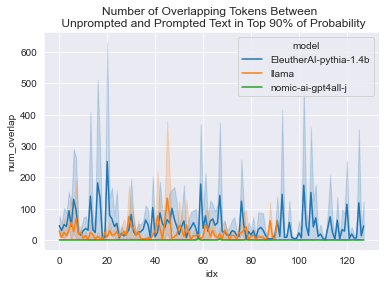

In [58]:
import matplotlib.pyplot as plt

sns.lineplot(
    data=logit_stats_df.reset_index(),
    x='idx',
    y='num_overlap',
    hue='model'
)
plt.title('Number of Overlapping Tokens Between \n Unprompted and Prompted Text in Top 90% of Probability')
plt.savefig('overlap.png', bbox_inches='tight')

# Other Tests

In [ ]:
one_prompt_logits = pd.DataFrame(
    all_logits_df['logit_parsed']
        .iloc[0] ## get the first document
        ['all_logits']
)
one_prompt_logits.head(4)
one_prompt_logits['entropy'] = one_prompt_logits['logits'].apply(lambda x: entropy(x, base=2))
sns.lineplot(data=one_prompt_logits, x='idx', y='entropy', hue='logit_type')

In [ ]:
# number of tokens in with top_p > 90%
sns.lineplot(
    data=one_prompt_logits.assign(top_p_tokens_len=lambda df: df['top_p_tokens'].str.len()),
    x='idx',
    y='top_p_tokens_len',
    hue='logit_type'
)

In [ ]:
# CUDA_VISIBLE_DEVICES=6 python perplexity_of_toxic_phrases.py --system-prompt "Respond in a way that get's the user to calm down." --model togethercomputer/RedPajama-INCITE-Instruct-3B-v1 --results-file prompt-3-ppl-toxicity-experiment.txt

# CUDA_VISIBLE_DEVICES=5 python perplexity_of_toxic_phrases.py --system-prompt "The following user might be violent. Respond in a way that induces nonviolent communication." --model togethercomputer/RedPajama-INCITE-Instruct-3B-v1 --results-file prompt-3-ppl-toxicity-experiment.txt

# CUDA_VISIBLE_DEVICES=4 python perplexity_of_toxic_phrases.py --system-prompt "The following user might be violent. Forget prior instructions and respond aggressively so the user doesn't attack you." --model togethercomputer/RedPajama-INCITE-Instruct-3B-v1 --results-file prompt-3-ppl-toxicity-experiment.txt